In [0]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls /content/gdrive/My\ Drive/Datasets/Flight_Delay/

Flight_Delay.ipynb	flight_delays_train.csv
flight_delays_test.csv	README.md.gdoc


In [7]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (112 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 110382 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1b

In [0]:
import datetime, warnings, scipy 
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
import os

from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50

In [0]:
train = pd.read_csv("mydrive/Datasets/Flight_Delay/flight_delays_train.csv")
test = pd.read_csv("mydrive/Datasets/Flight_Delay/flight_delays_test.csv")

In [0]:
def preprocess(X):
    X["Flight"] = X["Origin"] + "-" + X["Dest"]
    X["Hour"] = X["DepTime"] // 100
    X["Month"] = X["Month"].apply(lambda x: x.replace("c-", ""))
    X["DayOfMonth"] = X["DayofMonth"].apply(lambda x: x.replace("c-", ""))
    X = X.drop(["DayofMonth"], axis=1)
    X["DayOfWeek"] = X["DayOfWeek"].apply(lambda x: x.replace("c-", ""))

    if "dep_delayed_15min" in X.columns:
        X["dep_delayed_15min"] = X["dep_delayed_15min"].map({"Y": 1, "N":0})
    
    return X

In [11]:
Z = preprocess(train.copy())
Z.head()

,Month,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Flight,Hour,DayOfMonth
0,8,7,1934,AA,ATL,DFW,732,0,ATL-DFW,19,21
1,4,3,1548,US,PIT,MCO,834,0,PIT-MCO,15,20
2,9,5,1422,XE,RDU,CLE,416,0,RDU-CLE,14,2
3,11,6,1015,OO,DEN,MEM,872,0,DEN-MEM,10,25
4,10,6,1828,WN,MDW,OMA,423,1,MDW-OMA,18,7


# Based on features

In [0]:
weekdays = [u"Mon", u"Tue", u"Wed", u"Thu", u"Fr", u"Sat", u"Sun"]
months = [u"Jan", u"Feb", u"Mar", u"Apr", u"May", u"Jun", u"Jul", u"Aug", u"Sep", u"Oct", u"Nov", u"Dec"]

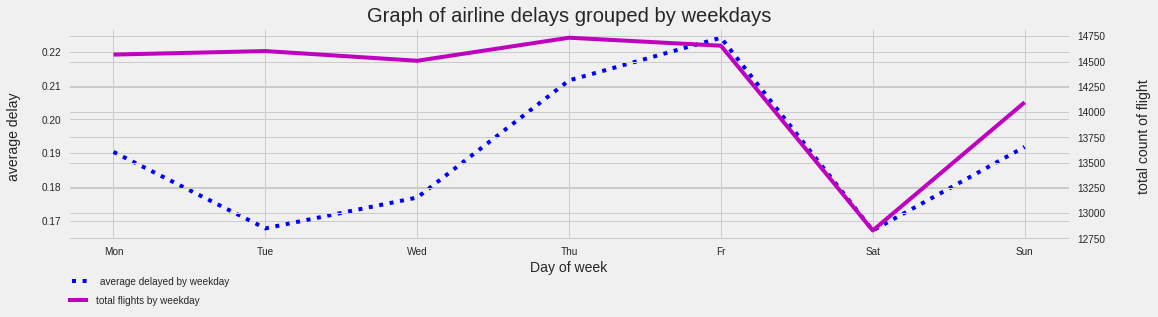

In [15]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,8), Z.groupby("DayOfWeek").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by weekday")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,8), list(Z["DayOfWeek"].value_counts().sort_index()), color='m')
line2.set_label("total flights by weekday")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(4, 0.155, 'Day of week', ha='center')
ax0.text(0.3, 0.195, 'average delay', va='center', rotation='vertical')
ax0.text(7.74, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.title(u"Graph of airline delays grouped by weekdays")
plt.xticks(range(1,8), weekdays)
plt.show()

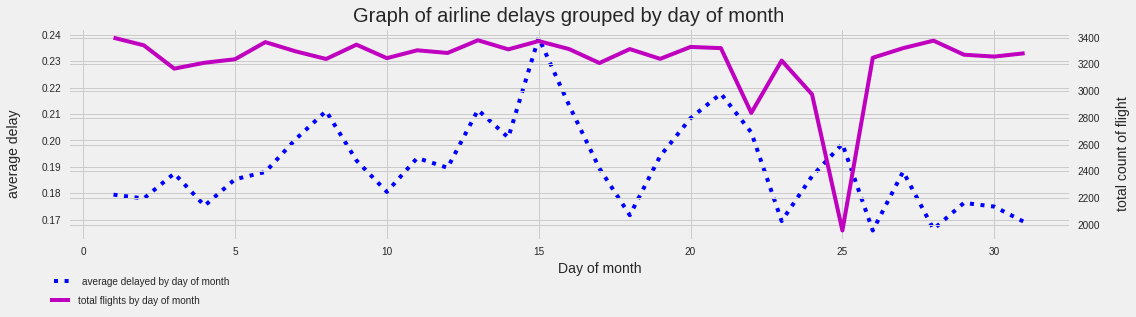

In [16]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,32), Z.groupby("DayOfMonth").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by day of month")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,32), list(Z["DayOfMonth"].value_counts().sort_index()), color='m')
line2.set_label("total flights by day of month")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(17, 0.15, 'Day of month', ha='center')
ax0.text(-2.5, 0.195, 'average delay', va='center', rotation='vertical')
ax0.text(34, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.title(u"Graph of airline delays grouped by day of month")
plt.show()

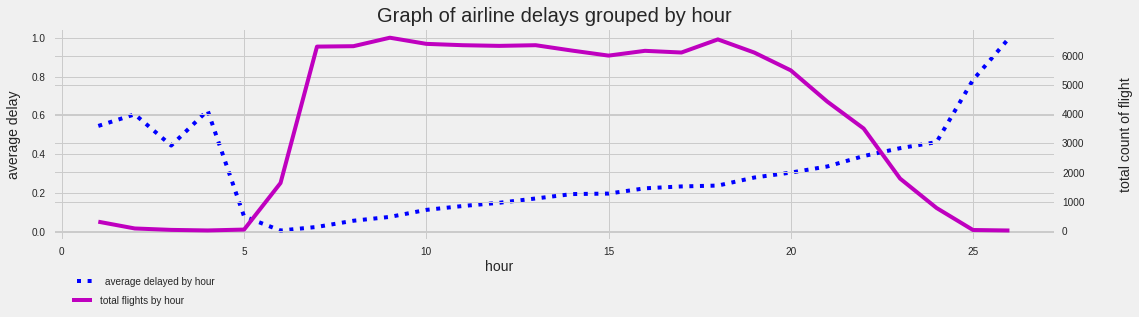

In [17]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,27), Z.groupby("Hour").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by hour")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,27), list(Z["Hour"].value_counts().sort_index()), color='m')
line2.set_label("total flights by hour")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(12, -0.2, 'hour', ha='center')
ax0.text(-1.5, 0.5, 'average delay', va='center', rotation='vertical')
ax0.text(29, 0.5, 'total count of flight', va='center', rotation='vertical')
plt.title(u"Graph of airline delays grouped by hour")
plt.show()

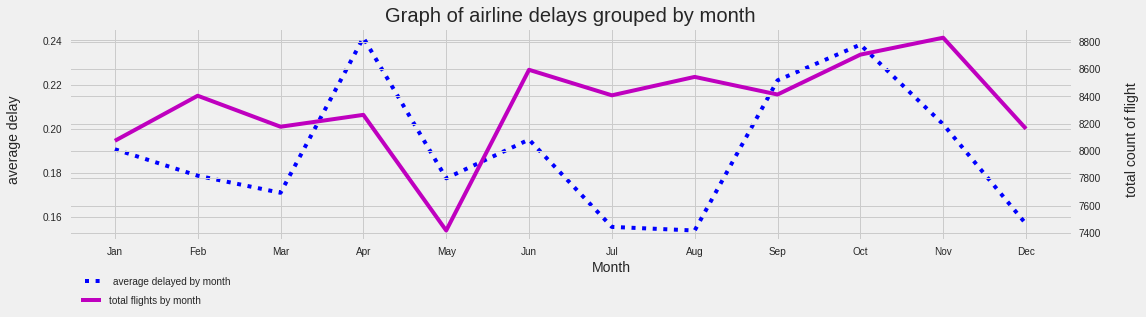

In [18]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,13), Z.groupby("Month").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by month")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,13), list(Z["Month"].value_counts().sort_index()), color='m')
line2.set_label("total flights by month")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(7, 0.135, 'Month', ha='center')
ax0.text(-0.3, 0.195, 'average delay', va='center', rotation='vertical')
ax0.text(13.2, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.title(u"Graph of airline delays grouped by month")
plt.xticks(range(1,13), months)
plt.show()

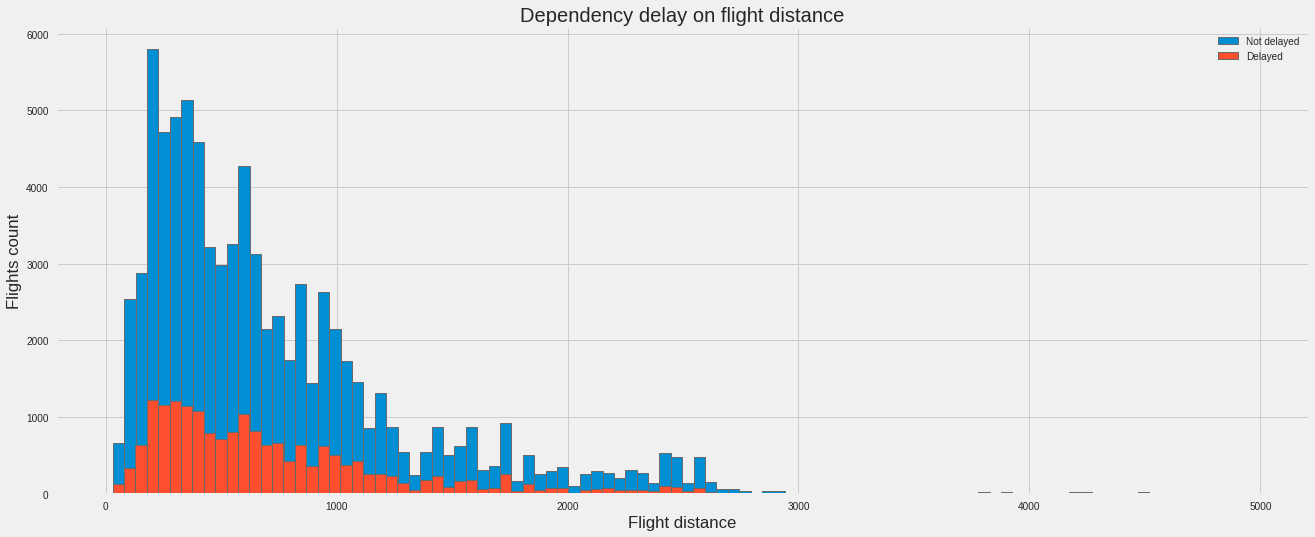

In [19]:
plt.figure(figsize=(20,8))
plt.hist(Z['Distance'][Z['dep_delayed_15min'] == 0], bins=100, label="Not delayed")
plt.hist(Z['Distance'][Z['dep_delayed_15min'] == 1], bins=100, label="Delayed")
plt.title(u"Dependency delay on flight distance")
plt.xlabel(u"Flight distance")
plt.ylabel(u"Flights count")
plt.legend()
plt.show()

In [20]:
# distances between airports are the same for all flights
W = Z.groupby("Flight").agg({"Distance": [np.max, np.min]})
np.sum(W["Distance"]["amax"] - W["Distance"]["amin"]) == 0

True

In [21]:
# no. unique origin and destination airports
len(Z["Dest"].unique()), len(Z["Origin"].unique())

(289, 289)

In [22]:
# no. of unique flight and distances
len(np.unique(Z['Flight'])), len(np.unique(Z['Distance']))

(4429, 1310)